# Explanation for individual
- We answer the following questions in this section.
    - What are the most influential attributes of a specific individual considering him/her prediction of a given model?
    - What is the most easist way to improve the prediction of a specific individual? For example, improving which attribute and to what extent can improve the prediction of an individual?
- The answers of above questions are generated by the explanation model QII proposed in paper [Algorithmic Transparency via Quantitative Input Influence: Theory and Experiments with Learning Systems](https://ieeexplore.ieee.org/abstract/document/7546525)
- We only consider the Unary QII since there are limited correlations between the attributes in our dataset.

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import ADS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def call_regression_model_qii(_model_name, _perturb_id, _data, _train_data):
    if _model_name == "linear":
        r_model = ADS.simpleLR(_train_data)
        pre_data, _ = ADS.prepareLR(_data)
    elif _model_name == "polynomial":
        r_model = ADS.polynomialLR(_train_data)
        pre_data, _ = ADS.preparePoly(_data)
    else: # random forest
        r_model = ADS.forest(_train_data)
        pre_data, _ = ADS.prepareForest(_data)
    y_pred = r_model.predict(pre_data[_perturb_id:_perturb_id+1])
    return y_pred[0]
def run_perturnation_individual(_data, _perturb_id, model_name="linear", perturb_level=20, p_times=10, split_times=10):
    res_df = pd.DataFrame(columns=["split_seed", "p_time", "perturb_att", "QII_res"])
    att_list = list(_data.columns[0:-1])
    for ai in att_list: # perturb each att
        for ri in range(split_times):
            data_train, data_test = train_test_split(_data, test_size=0.33, random_state=ri)
            orig_y = call_regression_model_qii(model_name, _perturb_id, _data, data_train)
            y_changes = []
            for pi in range(p_times):
                update_data = perturb_individual_att_value(data, _perturb_id, ai, perturb_level=perturb_level)
                cur_train, cur_test = train_test_split(update_data, test_size=0.33, random_state=ri)
                cur_y = call_regression_model_qii(model_name, _perturb_id, _data, cur_train)
                y_changes.append((cur_y - orig_y)/orig_y)
            avg_change = sum(y_changes) / p_times
            res_df.loc[res_df.shape[0]] = [ri, p_times, ai, avg_change]
    return res_df

def perturb_individual_att_value(_data, _perturb_id, _perturb_att, ascending_value=True, perturb_level=20):
    num_list = ["age", "bmi"]
    domain_cat_att = {"sex": 2,
                      "children": 6,
                      "smoker": 2,
                      "region": 4}
    
    cur_center = _data.loc[_perturb_id, _perturb_att]
    if _perturb_att in num_list: # for numerical att, randomly sample from uniform dist U(original_value-x, original_value+x)
        
        _data.loc[_perturb_id, _perturb_att] = np.random.uniform(cur_center,cur_center+perturb_level,1)
    else:# for categorical att, randomly sample from the domain of the attribute
        _data.loc[_perturb_id, _perturb_att] = random.randrange(0,domain_cat_att[_perturb_att])
        
    return _data

In [3]:
def get_most_influential_att(_res):
    return _res.loc[_res["QII_res"]==max(abs(_res["QII_res"])),"perturb_att"].values[0]
def visualize_explanation(_res, _perturb_id, _model):
    file_str = {"rf": "random forest",
               "lr": "linear regression",
               "pl": "polynomial regression"}
    plt.figure(figsize=[10,8],dpi=150)
    sns.set(style="darkgrid")
    sns.barplot(x="perturb_att", y="QII_res", data=_res)
    plt.xlabel("Attribute", fontsize=20)
    plt.ylabel("Change of Y (charges)", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([min(_res["QII_res"])-0.1, max(_res["QII_res"])+0.1])
    plt.title("Personalized Explanation for ID="+str(_perturb_id)+" ("+file_str[_model]+")", fontsize=20)
    plt.savefig("Explanation_"+_model+"_"+str(_perturb_id)+".png")

# Specify individual
- User can focus on the exlanation of a specific individual by giving the id of the individual.
- We use the index of people in the input data set as their ids.

In [5]:
cur_individual_idx = 5
data = pd.read_csv("insurance.csv")
data.loc[cur_individual_idx, :]

age                31
sex            female
bmi             25.74
children            0
smoker             no
region      southeast
charges       3756.62
Name: 5, dtype: object

# Explanation for Linear regression

In [5]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
cur_res = run_perturnation_individual(data, cur_individual_idx, model_name="linear")
cur_res.head(5)

,split_seed,p_time,perturb_att,QII_res
0,0,10,age,1.822220
1,1,10,age,0.414997
2,2,10,age,0.184761
3,3,10,age,0.041432
4,4,10,age,0.105283


In [6]:
r_seed = 0
cur_model_res = cur_res[cur_res["split_seed"]==r_seed]
print ("--------------------- FOR INDIVIDUAL "+str(cur_individual_idx)+" ----------------")
print ("--------------------- FOR ADS LINEAR REGRESSION (RANDOM SEED ="+str(r_seed)+") ----------------")
print("--------------------- MOST INFLUENTIAL ATTRIBUTE IS "+get_most_influential_att(cur_model_res)+" -----------------")

--------------------- FOR INDIVIDUAL 2 ----------------
--------------------- FOR ADS LINEAR REGRESSION (RANDOM SEED =0) ----------------
--------------------- MOST INFLUENTIAL ATTRIBUTE IS age -----------------


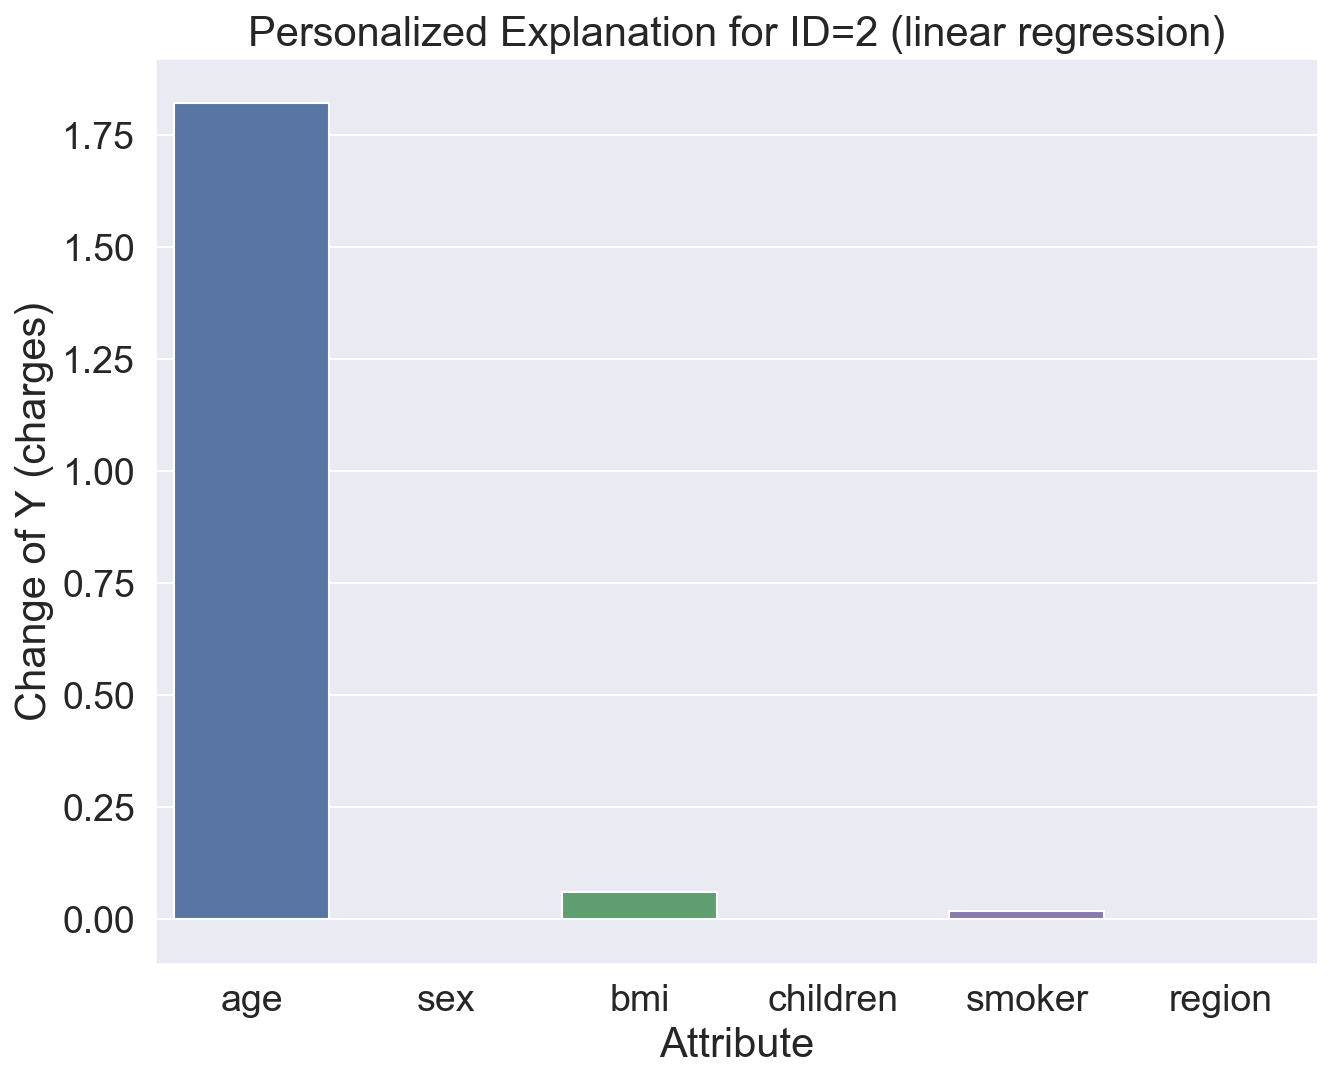

In [7]:
visualize_explanation(cur_model_res, cur_individual_idx, "lr")

# Explanation for Polynomial regression

In [8]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
cur_res = run_perturnation_individual(data, cur_individual_idx, model_name="polynomial")
cur_res.head(5)

,split_seed,p_time,perturb_att,QII_res
0,0,10,age,1.817168
1,1,10,age,-0.385109
2,2,10,age,0.578346
3,3,10,age,-0.065786
4,4,10,age,0.175207


In [9]:
r_seed = 0
cur_model_res = cur_res[cur_res["split_seed"]==r_seed]
print ("--------------------- FOR INDIVIDUAL "+str(cur_individual_idx)+" ----------------")
print ("--------------------- FOR ADS POLYNOMIAL REGRESSION (RANDOM SEED ="+str(r_seed)+") ----------------")
print("--------------------- MOST INFLUENTIAL ATTRIBUTE IS "+get_most_influential_att(cur_model_res)+" -----------------")

--------------------- FOR INDIVIDUAL 2 ----------------
--------------------- FOR ADS POLYNOMIAL REGRESSION (RANDOM SEED =0) ----------------
--------------------- MOST INFLUENTIAL ATTRIBUTE IS age -----------------


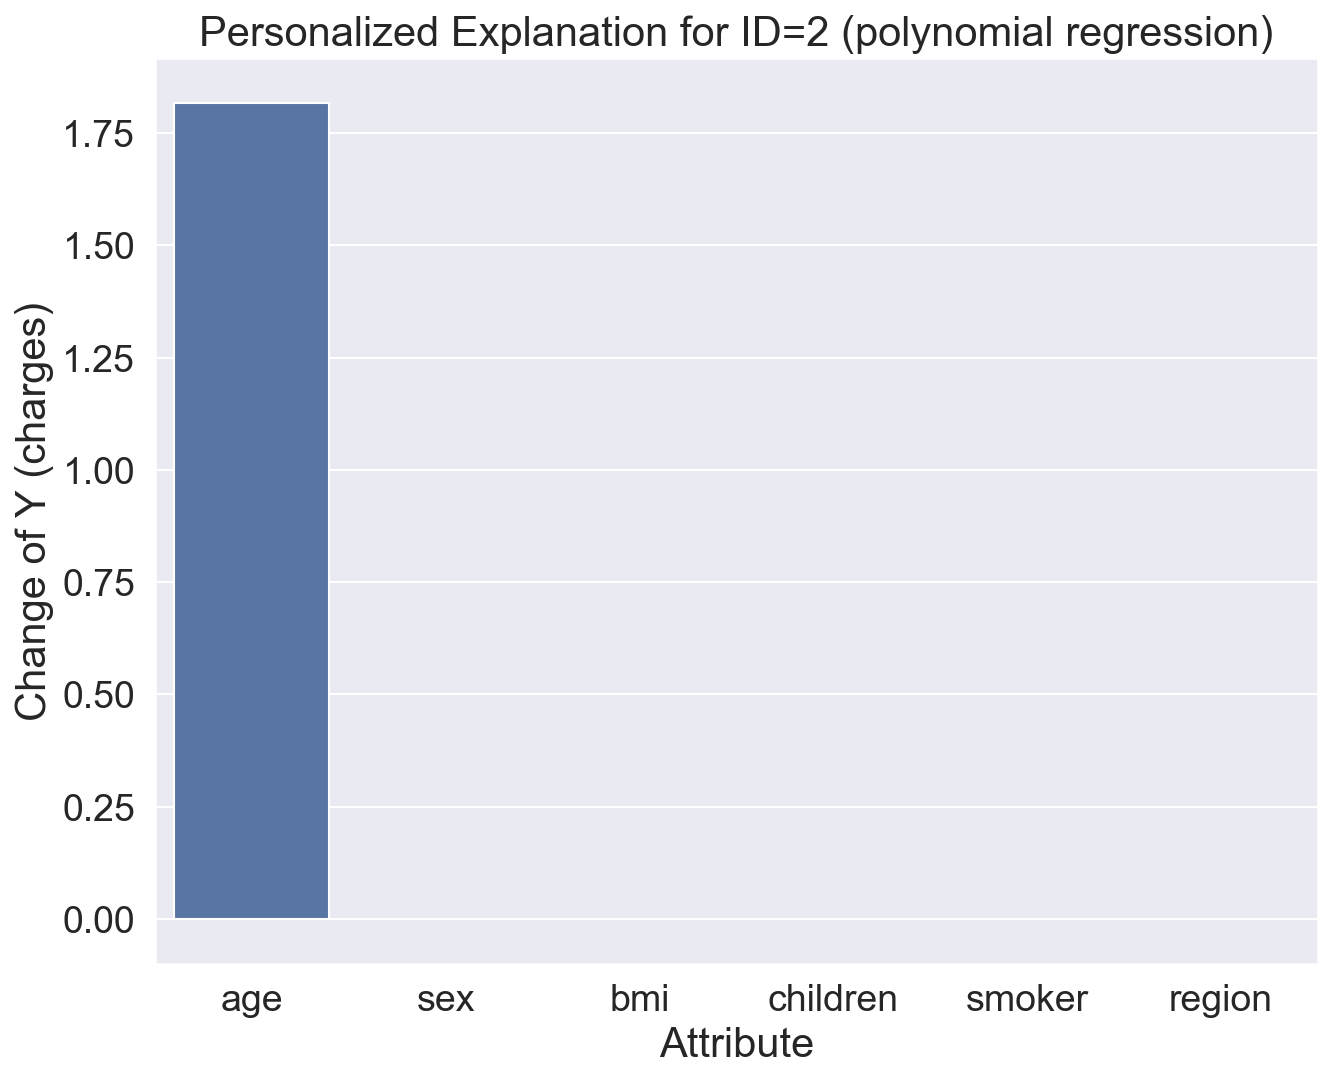

In [10]:
visualize_explanation(cur_model_res, cur_individual_idx, "pl")

# Explanation for Random forest

In [42]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
cur_res = run_perturnation_individual(data, cur_individual_idx, model_name="random")
cur_res.head(5)


,split_seed,p_time,perturb_att,QII_res
0,0,10,age,0.656151
1,1,10,age,0.000000
2,2,10,age,0.000000
3,3,10,age,0.000000
4,4,10,age,0.000000


In [43]:
r_seed = 0
cur_model_res = cur_res[cur_res["split_seed"]==r_seed]
print ("--------------------- FOR INDIVIDUAL "+str(cur_individual_idx)+" ----------------")
print ("--------------------- FOR ADS RANDOM FOREST (RANDOM SEED ="+str(r_seed)+") ----------------")
print("--------------------- MOST INFLUENTIAL ATTRIBUTE IS "+get_most_influential_att(cur_model_res)+" -----------------")

--------------------- FOR INDIVIDUAL 7 ----------------
--------------------- FOR ADS RANDOM FOREST (RANDOM SEED =0) ----------------
--------------------- MOST INFLUENTIAL ATTRIBUTE IS smoker -----------------


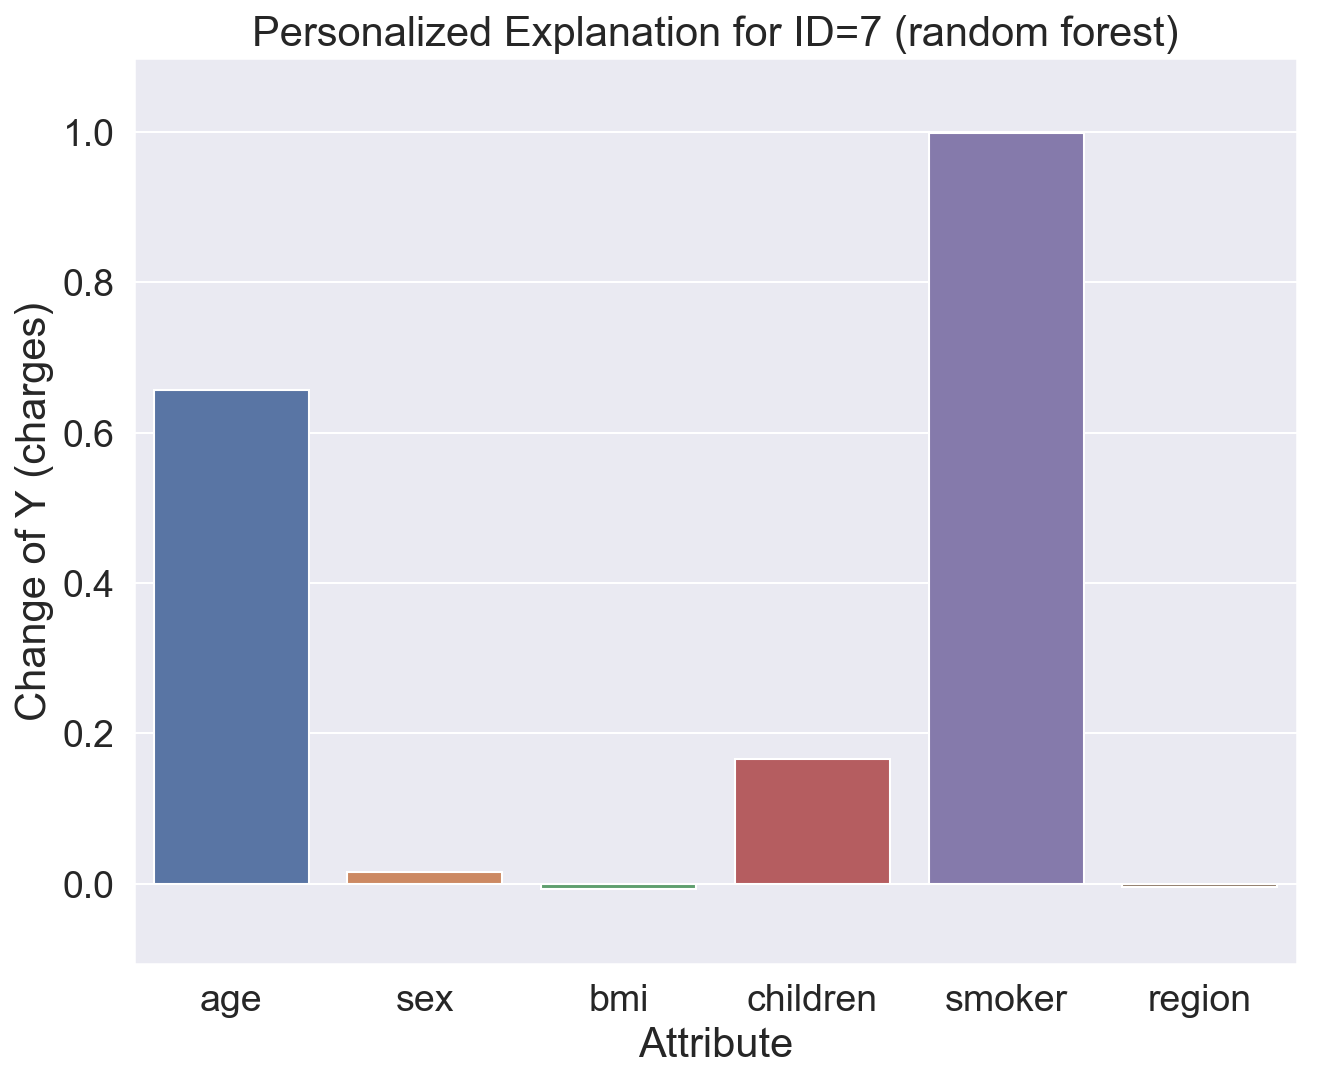

In [44]:
visualize_explanation(cur_model_res, cur_individual_idx, "rf")